
## In situ data and trajectories incl. Bepi Colombo, PSP, Solar Orbiter
https://github.com/cmoestl/heliocats

Author: C. Moestl, IWF Graz, Austria

twitter @chrisoutofspace, https://github.com/cmoestl

last update: 2021 August 24


needs python 3.7 with the conda helio environment (see README.md)


uses heliopy for generating spacecraft positions, for data source files see README.md

    
---

MIT LICENSE
Copyright 2020-2021, Christian Moestl 
Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:
The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
#change path for ffmpeg for animation production if needed

ffmpeg_path=''

import os
import datetime
from datetime import datetime, timedelta
from sunpy.time import parse_time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.cm as cmap


from scipy.signal import medfilt
import numpy as np
import pdb
import pickle
import seaborn as sns
import sys
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import astropy
import importlib    
import time
import numba
from numba import jit
import multiprocessing
import urllib
import copy
from astropy import constants as const




import warnings
warnings.filterwarnings('ignore')

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path

## load HIGeoCAT

In [3]:
#load HIGeoCAT
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging 

#https://www.helcats-fp7.eu/
#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

sse_speed=higeocat['SSE Speed']
sse_lon=higeocat['SSE HEEQ Long']
sse_lat=higeocat['SSE HEEQ Lat']
higeocat_name=np.array(higeocat['SC'].astype(str))



print('done')

done


## generate HIGeoCAT kinematics


In [4]:
print('generate kinematics for each SSEF30 CME')




generate_hi_kin=False


if generate_hi_kin:
    
    t0=higeocat_t0

    kindays=60

    #lists for all times, r, longitude, latitude
    all_time=[]
    all_r=[]
    all_lat=[]
    all_lon=[]
    all_name=[]

    #go through all HI CMEs
    for i in np.arange(len(higeocat)):

    #for i in np.arange(100):

        #times for each event kinematic
        time1=[]
        tstart1=copy.deepcopy(t0[i])
        tend1=tstart1+timedelta(days=kindays)
        #make 30 min datetimes
        while tstart1 < tend1:
            time1.append(tstart1)  
            tstart1 += timedelta(minutes=30)    


        #make kinematics
        timestep=np.zeros(kindays*24*2)
        cme_r=np.zeros(kindays*24*2)
        cme_lon=np.zeros(kindays*24*2)
        cme_lat=np.zeros(kindays*24*2)
        cme_name=np.chararray(kindays*24*2)




        for j in np.arange(0,len(cme_r)-1,1):

            cme_r[j]=sse_speed[i]*timestep[j]/(const.au.value*1e-3) #km to AU
            cme_lon[j]=sse_lon[i]
            cme_lat[j]=sse_lat[i]
            timestep[j+1]=timestep[j]+30*60 #seconds
            cme_name[j]=higeocat_name[i]



        #### linear interpolate to 30 min resolution

        #find next full hour after t0
        format_str = '%Y-%m-%d %H'  
        t0r = datetime.strptime(datetime.strftime(t0[i], format_str), format_str) +timedelta(hours=1)
        time2=[]
        tstart2=copy.deepcopy(t0r)
        tend2=tstart2+timedelta(days=kindays)
        #make 30 min datetimes 
        while tstart2 < tend2:
            time2.append(tstart2)  
            tstart2 += timedelta(minutes=30)  

        time2_num=parse_time(time2).plot_date        
        time1_num=parse_time(time1).plot_date



        #linear interpolation to time_mat times    
        cme_r = np.interp(time2_num, time1_num,cme_r )
        cme_lat = np.interp(time2_num, time1_num,cme_lat )
        cme_lon = np.interp(time2_num, time1_num,cme_lon )



        #cut at 5 AU    
        cutoff=np.where(cme_r<5)[0]
        #write to all
        #print(cutoff[0],cutoff[-1])
        all_time.extend(time2[cutoff[0]:cutoff[-2]])
        all_r.extend(cme_r[cutoff[0]:cutoff[-2]])
        all_lat.extend(cme_lat[cutoff[0]:cutoff[-2]])
        all_lon.extend(cme_lon[cutoff[0]:cutoff[-2]])
        all_name.extend(cme_name[cutoff[0]:cutoff[-2]])






    plt.figure(1)    
    plt.plot(all_time,all_r)

    plt.figure(2)    
    plt.plot(all_time,all_lat,'ok')


    plt.figure(3)    
    plt.plot(all_time,all_lon,'ok')

    ################### sort all kinematics by time
    all_time_num=mdates.date2num(all_time)


    all_r=np.array(all_r)
    all_lat=np.array(all_lat)
    all_lon=np.array(all_lon)


    all_name=np.array(all_name)

    #get indices for sorting for time
    sortind=np.argsort(all_time_num,axis=0)

    #cme_time_sort=mdates.num2date(all_time_num[sortind])
    cme_time_sort_num=all_time_num[sortind]
    cme_r_sort=all_r[sortind]
    cme_lat_sort=all_lat[sortind]
    cme_lon_sort=all_lon[sortind]
    cme_name_sort=all_name[sortind].astype(str)


    #plt.plot(cme_time_sort,cme_r_sort)
    #plt.plot(cme_time_sort,cme_r_sort)
    plt.figure(4)    
    plt.plot(all_time,all_lon,'.k')
    plt.plot(cme_time_sort_num,cme_lon_sort,'.b')

    pickle.dump([cme_time_sort_num,cme_r_sort,cme_lat_sort,cme_lon_sort,cme_name_sort], open('data/higeocat_kinematics.p', "wb"))



print('load HIGEOCAT kinematics')
[hc_time_num,hc_r,hc_lat,hc_lon,hc_name]=pickle.load(open('data/higeocat_kinematics.p', "rb"))


print('done')

generate kinematics for each SSEF30 CME
load HIGEOCAT kinematics
done


### define functions

In [5]:
def make_positions():

    ###############  PSP

    starttime =datetime(2018, 8,13)
    endtime = datetime(2025, 8, 31)
    psp_time = []
    while starttime < endtime:
        psp_time.append(starttime)
        starttime += timedelta(days=res_in_days)
    psp_time_num=mdates.date2num(psp_time)     

    spice.furnish(spicedata.get_kernel('psp_pred'))
    psp=spice.Trajectory('SPP')
    psp.generate_positions(psp_time,'Sun',frame)
    print('PSP pos')

    psp.change_units(astropy.units.AU)  
    [psp_r, psp_lat, psp_lon]=hd.cart2sphere(psp.x,psp.y,psp.z)
    print('PSP conv')


    ############### BepiColombo

    starttime =datetime(2018, 10, 21)
    endtime = datetime(2025, 11, 2)
    bepi_time = []
    while starttime < endtime:
        bepi_time.append(starttime)
        starttime += timedelta(days=res_in_days)
    bepi_time_num=mdates.date2num(bepi_time) 

    spice.furnish(spicedata.get_kernel('bepi_pred'))
    bepi=spice.Trajectory('BEPICOLOMBO MPO') # or BEPICOLOMBO MMO
    bepi.generate_positions(bepi_time,'Sun',frame)
    bepi.change_units(astropy.units.AU)  
    [bepi_r, bepi_lat, bepi_lon]=hd.cart2sphere(bepi.x,bepi.y,bepi.z)
    print('Bepi')



    ############### Solar Orbiter

    starttime = datetime(2020, 3, 1)
    endtime = datetime(2029, 12, 31)
    solo_time = []
    while starttime < endtime:
        solo_time.append(starttime)
        starttime += timedelta(days=res_in_days)
    solo_time_num=mdates.date2num(solo_time) 

    spice.furnish(spicedata.get_kernel('solo_2020'))
    solo=spice.Trajectory('Solar Orbiter')
    solo.generate_positions(solo_time, 'Sun',frame)
    solo.change_units(astropy.units.AU)
    [solo_r, solo_lat, solo_lon]=hd.cart2sphere(solo.x,solo.y,solo.z)
    print('Solo')



    ########### plots


    plt.figure(1, figsize=(12,9))
    plt.plot_date(psp_time,psp_r,'-', label='R')
    plt.plot_date(psp_time,psp_lat,'-',label='lat')
    plt.plot_date(psp_time,psp_lon,'-',label='lon')
    plt.ylabel('AU / RAD')
    plt.legend()

    plt.figure(2, figsize=(12,9))
    plt.plot_date(bepi_time,bepi_r,'-', label='R')
    plt.plot_date(bepi_time,bepi_lat,'-',label='lat')
    plt.plot_date(bepi_time,bepi_lon,'-',label='lon')
    plt.title('Bepi Colombo position '+frame)
    plt.ylabel('AU / RAD')
    plt.legend()


    plt.figure(3, figsize=(12,9))
    plt.plot_date(solo_time,solo_r,'-', label='R')
    plt.plot_date(solo_time,solo_lat,'-',label='lat')
    plt.plot_date(solo_time,solo_lon,'-',label='lon')
    plt.title('Solar Orbiter position '+frame)
    plt.ylabel('AU / RAD')
    plt.legend()


    ######## R with all three
    plt.figure(4, figsize=(16,10))
    plt.plot_date(psp_time,psp.r,'-',label='PSP')
    plt.plot_date(bepi_time,bepi.r,'-',label='Bepi Colombo')
    plt.plot_date(solo_time,solo.r,'-',label='Solar Orbiter')
    plt.legend()
    plt.title('Heliocentric distance of heliospheric observatories')
    plt.ylabel('AU')
    plt.savefig(positions_plot_directory+'/bepi_psp_solo_R.png')

    ##### Longitude all three
    plt.figure(5, figsize=(16,10))
    plt.plot_date(psp_time,psp_lon*180/np.pi,'-',label='PSP')
    plt.plot_date(bepi_time,bepi_lon*180/np.pi,'-',label='Bepi Colombo')
    plt.plot_date(solo_time,solo_lon*180/np.pi,'-',label='Solar Orbiter')
    plt.legend()
    plt.title(frame+' longitude')
    plt.ylabel('DEG')
    plt.savefig(positions_plot_directory+'/bepi_psp_solo_longitude_'+frame+'.png')

    ############# Earth, Mercury, Venus, STA
    #see https://docs.heliopy.org/en/stable/data/spice.html

    planet_kernel=spicedata.get_kernel('planet_trajectories')

    starttime =datetime(2018, 1, 1)
    endtime = datetime(2029, 12, 31)
    earth_time = []
    while starttime < endtime:
        earth_time.append(starttime)
        starttime += timedelta(days=res_in_days)
    earth_time_num=mdates.date2num(earth_time)     

    earth=spice.Trajectory('399')  #399 for Earth, not barycenter (because of moon)
    earth.generate_positions(earth_time,'Sun',frame)
    earth.change_units(astropy.units.AU)  
    [earth_r, earth_lat, earth_lon]=hd.cart2sphere(earth.x,earth.y,earth.z)
    print('Earth')

    ################ mercury
    mercury_time_num=earth_time_num
    mercury=spice.Trajectory('1')  #barycenter
    mercury.generate_positions(earth_time,'Sun',frame)  
    mercury.change_units(astropy.units.AU)  
    [mercury_r, mercury_lat, mercury_lon]=hd.cart2sphere(mercury.x,mercury.y,mercury.z)
    print('mercury') 

    ################# venus
    venus_time_num=earth_time_num
    venus=spice.Trajectory('2')  
    venus.generate_positions(earth_time,'Sun',frame)  
    venus.change_units(astropy.units.AU)  
    [venus_r, venus_lat, venus_lon]=hd.cart2sphere(venus.x,venus.y,venus.z)
    print('venus') 

    ############### Mars

    mars_time_num=earth_time_num
    mars=spice.Trajectory('4')  
    mars.generate_positions(earth_time,'Sun',frame)  
    mars.change_units(astropy.units.AU)  
    [mars_r, mars_lat, mars_lon]=hd.cart2sphere(mars.x,mars.y,mars.z)
    print('mars') 

    #############stereo-A
    sta_time_num=earth_time_num
    spice.furnish(spicedata.get_kernel('stereo_a_pred'))
    sta=spice.Trajectory('-234')  
    sta.generate_positions(earth_time,'Sun',frame)  
    sta.change_units(astropy.units.AU)  
    [sta_r, sta_lat, sta_lon]=hd.cart2sphere(sta.x,sta.y,sta.z)
    print('STEREO-A') 



    #save positions 
    if high_res_mode:
     pickle.dump([psp_time,psp_time_num,psp_r,psp_lon,psp_lat,bepi_time,bepi_time_num,bepi_r,bepi_lon,bepi_lat,solo_time,solo_time_num,solo_r,solo_lon,solo_lat], open( 'positions_plots/psp_solo_bepi_'+frame+'_1min.p', "wb" ) )
    else: 
     psp=np.rec.array([psp_time_num,psp_r,psp_lon,psp_lat, psp.x, psp.y,psp.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     bepi=np.rec.array([bepi_time_num,bepi_r,bepi_lon,bepi_lat,bepi.x, bepi.y,bepi.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     solo=np.rec.array([solo_time_num,solo_r,solo_lon,solo_lat,solo.x, solo.y,solo.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     sta=np.rec.array([sta_time_num,sta_r,sta_lon,sta_lat,sta.x, sta.y,sta.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     earth=np.rec.array([earth_time_num,earth_r,earth_lon,earth_lat, earth.x, earth.y,earth.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     venus=np.rec.array([venus_time_num,venus_r,venus_lon,venus_lat, venus.x, venus.y,venus.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     mars=np.rec.array([mars_time_num,mars_r,mars_lon,mars_lat, mars.x, mars.y,mars.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     mercury=np.rec.array([mercury_time_num,mercury_r,mercury_lon,mercury_lat,mercury.x, mercury.y,mercury.z],dtype=[('time','f8'),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
     pickle.dump([psp, bepi, solo, sta, earth, venus, mars, mercury,frame], open( 'data/positions_psp_solo_bepi_sta_planets_'+frame+'_1hour.p', "wb" ) )
     #load with [psp, bepi, solo, sta, earth, venus, mars, mercury,frame]=pickle.load( open( 'positions_psp_solo_bepi_sta_planets_HCI_6hours_2018_2025.p', "rb" ) )
 
 
    end=time.time()
    print( 'generate position took time in seconds:', round((end-start),1) )

In [6]:
def make_frame(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((7,2), (0, 0), rowspan=7, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    #print( 'current frame_time_num', frame_time_str, '     ',k)

    #these have their own times
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, earth_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[earth_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, alpha=0.6,lw=1,zorder=3)

    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, alpha=0.6,lw=1,zorder=3)

    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    
    
    

    ######################## 1 plot all active CME circles

    plot_hi_geo=True
    
    
    if plot_hi_geo:
        lamda=30
        #check for active CME indices from HIGeoCAT (with the lists produced above in this notebook)
        #check where time is identical to frame time
        cmeind=np.where(hc_time_num == frame_time_num+k*res_in_days)
        #print(cmeind)
        #plot all active CME circles
        #if np.size(cmeind) >0:
        for p in range(0,np.size(cmeind)):

            #print p, h.all_apex_long[cmeind[0][p]], h.all_apex_r[cmeind[0][p]]
            #central d
            dir=np.array([np.cos(hc_lon[cmeind[0][p]]*np.pi/180),np.sin(hc_lon[cmeind[0][p]]*np.pi/180)])*hc_r[cmeind[0][p]]

            #points on circle, correct for longitude
            circ_ang = ((np.arange(111)*2-20)*np.pi/180)-(hc_lon[cmeind[0][p]]*np.pi/180)

            #these equations are from moestl and davies 2013
            xc = 0+dir[0]/(1+np.sin(lamda*np.pi/180)) + (hc_r[cmeind[0][p]]*np.sin(lamda*np.pi/180)/(1+np.sin(lamda*np.pi/180)))*np.sin(circ_ang)
            yc = 0+dir[1]/(1+np.sin(lamda*np.pi/180)) + (hc_r[cmeind[0][p]]*np.sin(lamda*np.pi/180)/(1+np.sin(lamda*np.pi/180)))*np.cos(circ_ang)
            #now convert to polar coordinates
            rcirc=np.sqrt(xc**2+yc**2)
            longcirc=np.arctan2(yc,xc)
            #plot in correct color
            if hc_name[cmeind[0][p]] == 'A':    
                #make alpha dependent on distance to solar equatorial plane - maximum latitude is -40/+40 - 
                #so to make also the -/+40 latitude CME visible, divide by 50 so alpha > 0 for these events
                ax.plot(longcirc,rcirc, c='red', alpha=1-abs(hc_lat[cmeind[0][p]]/50), lw=1.5) 
            if hc_name[cmeind[0][p]] == 'B':
                ax.plot(longcirc,rcirc, c='royalblue', alpha=1-abs(hc_lat[cmeind[0][p]]/50), lw=1.5) 

    
    


    #parker spiral
    if plot_parker:
        for q in np.arange(0,12):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            if not black: 
                ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.4, lw=0.5,color='grey',zorder=2)
            if black: 
                ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.7, lw=0.7,color='grey',zorder=2)

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2) 

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster
            
    windex1=np.where(w_time_num > time_now-days_window)[0][0]
    windex2=np.where(w_time_num > time_now+days_window)[0][0]
    w=w1[windex1:windex2]

    sindex1=np.where(s_time_num > time_now-days_window)[0][0]
    sindex2=np.where(s_time_num > time_now+days_window)[0][0]
    s=s1[sindex1:sindex2]

    #is data available from new missions?
    
    if p_time_num[-1] > time_now+days_window:
        pindex1=np.where(p_time_num > time_now-days_window)[0][0]
        pindex2=np.where(p_time_num > time_now+days_window)[0][0]
        #pindex2=np.size(p1)-1
        p=p1[pindex1:pindex2]
    elif np.logical_and((p_time_num[-1] < time_now+days_window),(p_time_num[-1] > time_now-days_window)):
        pindex1=np.where(p_time_num > time_now-days_window)[0][0]
        pindex2=np.size(p1)-1
        p=p1[pindex1:pindex2]
    else: p=[]  

    
    if o_time_num[-1] > time_now+days_window:
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.where(o_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        o=o1[oindex1:oindex2]
    elif np.logical_and((o_time_num[-1] < time_now+days_window),(o_time_num[-1] > time_now-days_window)):
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.size(o1)-1
        o=o1[oindex1:oindex2]
    else: o=[]    


    if b_time_num[-1] > time_now+days_window:
        bindex1=np.where(b_time_num > time_now-days_window)[0][0]
        bindex2=np.where(b_time_num > time_now+days_window)[0][0]
        #bindex2=np.size(b1)-1
        b=b1[bindex1:bindex2]
    else: b=[]    




    #---------------- Wind mag

    ax4 = plt.subplot2grid((7,2), (0, 1))
    #plt.plot_date(w_tm,wbx,'-r',label='BR',linewidth=0.5)
    #plt.plot_date(w_tm,wby,'-g',label='BT',linewidth=0.5)
    #plt.plot_date(w_tm,wbz,'-b',label='BN',linewidth=0.5)
    #plt.plot_date(w_tm,wbt,'-k',label='Btotal',lw=0.5)
    plt.plot_date(w.time,w.bx,'-r',label='BR',linewidth=0.5)
    plt.plot_date(w.time,w.by,'-g',label='BT',linewidth=0.5)
    plt.plot_date(w.time,w.bz,'-b',label='BN',linewidth=0.5)
    plt.plot_date(w.time,w.bt,'-k',label='Btotal',lw=0.5)

    ax4.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax4.set_ylabel('B [nT] HEEQ',fontsize=fsize-1)
    ax4.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylim(np.nanmin(-w.bt)-5, np.nanmax(w.bt)+5)
    #plt.ylim((-18, 18))
    plt.yticks(fontsize=fsize-1) 
    ax4.set_xticklabels([])


    #----------------  STEREO-A mag

    ax6 = plt.subplot2grid((7,2), (1, 1))
    #plt.plot_date(s_tm,sbx,'-r',label='BR',linewidth=0.5)
    #plt.plot_date(s_tm,sby,'-g',label='BT',linewidth=0.5)
    #plt.plot_date(s_tm,sbz,'-b',label='BN',linewidth=0.5)
    #plt.plot_date(s_tm,sbt,'-k',label='Btotal')
    plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
    plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
    plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
    plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)

    ax6.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    #ax6.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    #plt.ylim((-18, 18))
    
    #----------------  STEREO, Wind speed    
    
    ax5 = plt.subplot2grid((7,2), (2, 1))
    plt.plot_date(w.time,w.vt,'-g',label='Wind',linewidth=0.7)
    plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)

    #ax5.legend(loc=1, fontsize=10)
    ax5.plot_date([time_now,time_now], [0,900],'-k', lw=0.5, alpha=0.8)
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 750))
    plt.yticks(fontsize=fsize-1) 
    ax5.set_xticklabels([])
        

    #ax7 = plt.subplot2grid((6,2), (5, 1))
    #plt.plot_date(s.time,s.vt,'-k',label='V',linewidth=0.7)
    #ax7.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
    #ax7.set_xlim(time_now-days_window,time_now+days_window)
    #ax7.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    #plt.ylabel('V [km/s]',fontsize=fsize-1)
    #plt.tick_params(axis='x', labelbottom='off') 
    #plt.ylim((240, 810))
    #plt.yticks(fontsize=fsize-1)
    #plt.xticks(fontsize=fsize)

    #---------------------- PSP speed

    ax3 = plt.subplot2grid((7,2), (3, 1))
    
    ax3.plot_date([time_now,time_now], [0,1000],'-k', lw=0.5, alpha=0.8)
    ax3.set_xticklabels([])
    ax3.set_xlim(time_now-days_window,time_now+days_window)
    ax3.set_ylim((240, 810))
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)
    ax3.set_xticklabels([])

   
    if np.size(p)>0:
    
        #plt.plot_date(p_tp,pv,'-k',label='V',linewidth=0.5)
        plt.plot_date(p.time,p.vt,'-k',label='V',linewidth=0.7)

        ax3.set_xlim(time_now-days_window,time_now+days_window)
        ax3.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
        ax3.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        plt.ylabel('V [km/s]',fontsize=fsize-1)
        plt.ylim((240, 750))
        plt.yticks(fontsize=fsize-1)
        ax3.set_xticklabels([])


    

    #---------------------- PSP mag

    ax2 = plt.subplot2grid((7,2), (4, 1))
    ax2.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
    ax2.set_xticklabels([])
    ax2.set_xlim(time_now-days_window,time_now+days_window)
    ax2.set_ylim((-18, 18))
    ax2.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(p)>0:

        plt.plot_date(p.time,p.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(p.time,p.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(p.time,p.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(p.time,p.bt,'-k',label='Btotal',lw=0.5)

        ax2.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
        ax2.set_ylabel('B [nT] RTN',fontsize=fsize-1)
        ax2.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        ax2.set_xlim(time_now-days_window,time_now+days_window)
        if np.isfinite(np.nanmin(-p.bt)):         ax2.set_ylim(np.nanmin(-p.bt)-5, np.nanmax(p.bt)+5)
        ax2.set_xticklabels([])
        plt.yticks(fontsize=fsize-1)
    

    #---------------------- SolO mag

    ax7 = plt.subplot2grid((7,2), (5, 1))
    ax7.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax7.set_xticklabels([])
    ax7.set_xlim(time_now-days_window,time_now+days_window)
    ax7.set_ylim((-18, 18))
    ax7.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)
    ax7.set_xticklabels([])

    #when there is data, plot:
    
    if np.size(o)>0:
    
        plt.plot_date(o.time,o.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(o.time,o.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(o.time,o.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(o.time,o.bt,'-k',label='Btotal',lw=0.5)
        
        ax7.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
        ax7.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        ax7.set_xlim(time_now-days_window,time_now+days_window)
        
        
        if np.isfinite(np.nanmax(o.bt)):
            ax7.set_ylim((np.nanmin(-o.bt)-5, np.nanmax(o.bt)+5))        
        else:
            ax7.set_ylim((-15, 15))        

    
        ax7.set_xticklabels([])
        plt.yticks(fontsize=fsize-1)
        

    
    #---------------------- Bepi mag

    ax8 = plt.subplot2grid((7,2), (6, 1))
    ax8.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax8.set_xlim(time_now-days_window,time_now+days_window)
    ax8.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax8.set_ylim((-18, 18))
    ax8.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    if np.size(b)>0:

        plt.plot_date(b.time,b.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(b.time,b.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(b.time,b.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(b.time,b.bt,'-k',label='Btotal',lw=0.5)

        ax8.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
        ax8.set_ylabel('B [nT] RTN',fontsize=fsize-1)
        ax8.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        ax8.set_xlim(time_now-days_window,time_now+days_window)
        
        if np.isfinite(np.nanmax(b.bt)):
            ax8.set_ylim((np.nanmin(-b.bt)-5, np.nanmax(b.bt)+5))        
        else:
            ax8.set_ylim((-15, 15))        

        #ax8.set_ylim((np.nanmin(-b.bt)-5, np.nanmax(b.bt)+5))
        plt.yticks(fontsize=fsize-1)

    plt.figtext(0.95,0.82,'Wind', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.71,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.63,'Wind', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.58,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'PSP ', color='black', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.38,'PSP ', color='black', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.28,'Solar Orbiter', color='coral', ha='center',fontsize=fsize+5)
    plt.figtext(0.95,0.16,'BepiColombo', color='blue', ha='center',fontsize=fsize+5)



    ############################

    #plot text for date extra so it does not move 
    #year
    f1=plt.figtext(0.45,0.93,frame_time_str[0:4],  ha='center',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.45+0.04,0.93,frame_time_str[5:7], ha='center',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.45+0.08,0.93,frame_time_str[8:10], ha='center',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.45+0.12,0.93,frame_time_str[11:13], ha='center',color=backcolor,fontsize=fsize+6)

    plt.figtext(0.02, 0.02,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)	
    
    plt.figtext(0.32,0.02,'――― trajectory from - 60 days to + 60 days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.85,0.02,'Data sources: BepiColombo: MPO-MAG (IGEP/IWF/ISAS/IC), PSP (FIELDS, UCB), Solar Orbiter (MAG, IC)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.99,0.01/2,'Möstl, Weiss, Bailey, Reiss / Helio4Cast', fontsize=fsize-4, ha='right',color=backcolor) 

    #save figure
    framestr = '%05i' % (k)  
    filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    if k==0: print(filename)
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')


    plt.close('all')



    ########################################### loop end

current frame_time_num 2020-11-23 07:00:00+00:00       10910


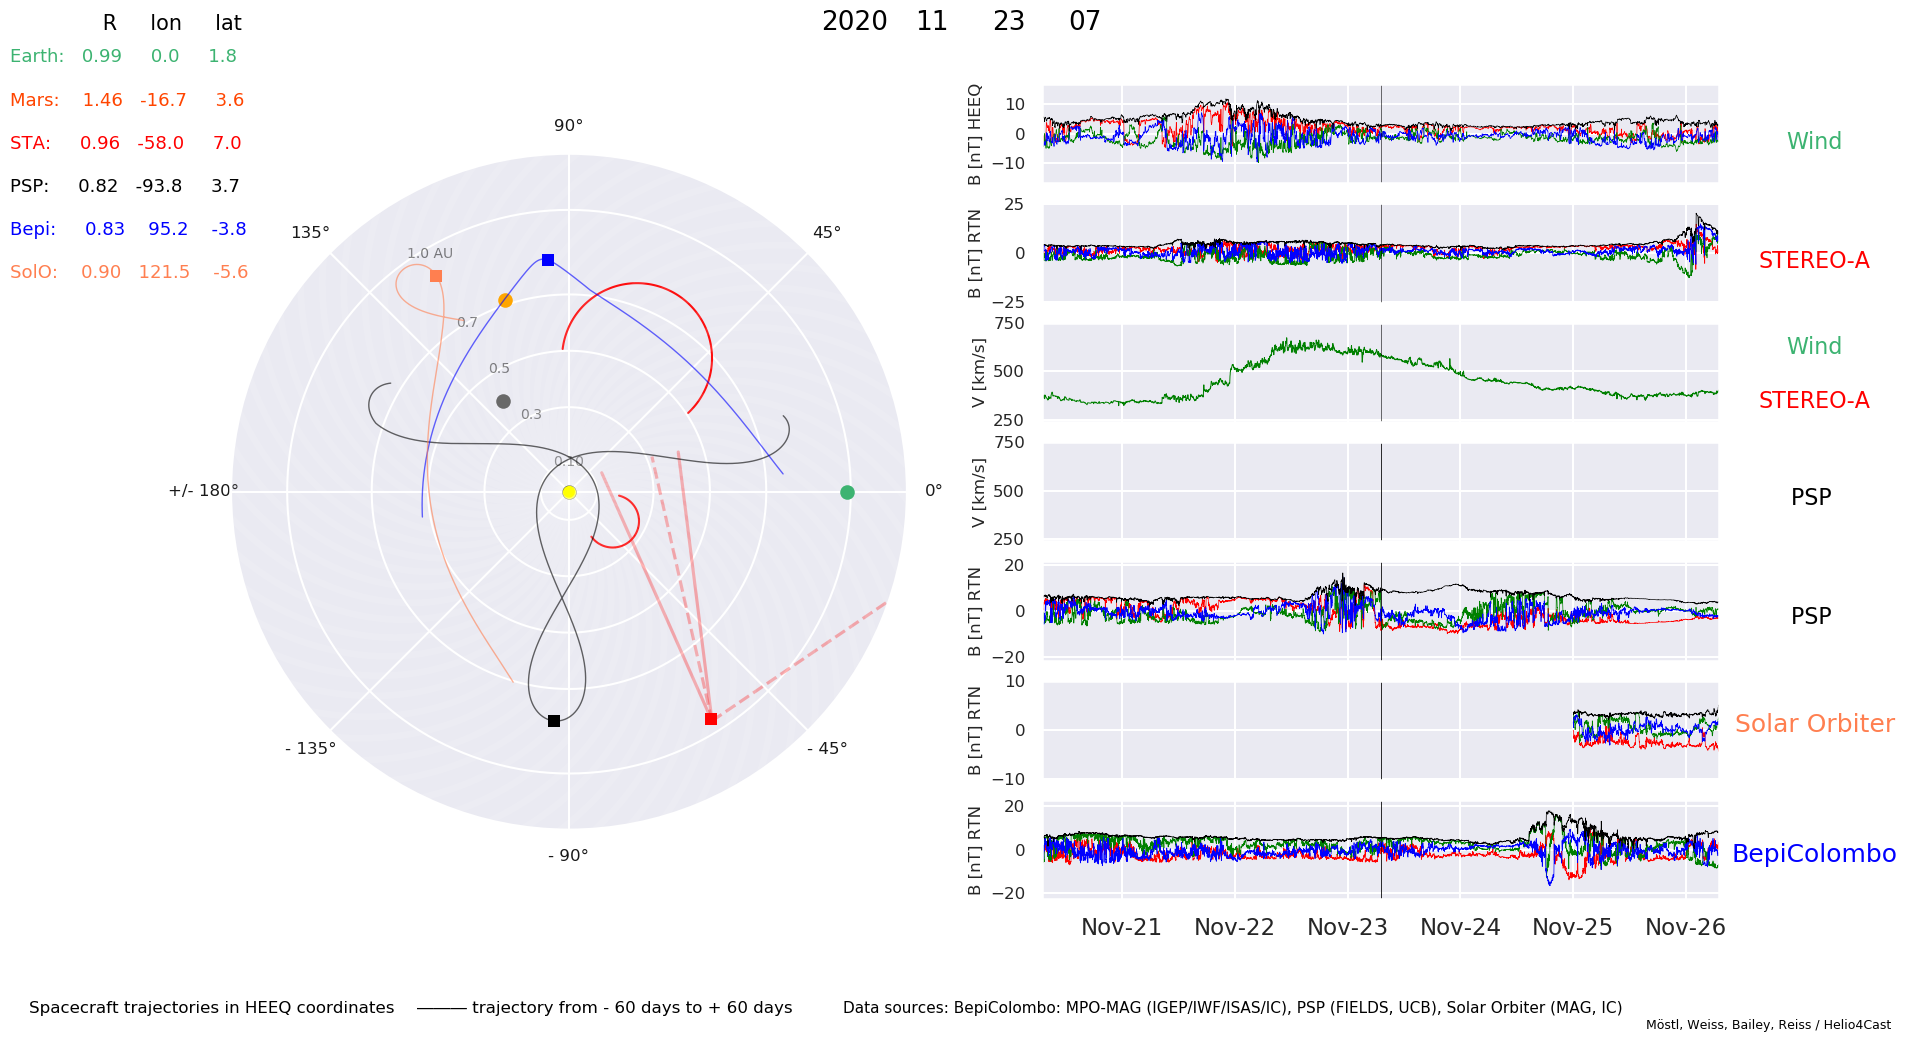

In [36]:
def make_frame2(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((7,2), (0, 0), rowspan=7, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    print( 'current frame_time_num', frame_time_str, '     ',k)

    #these have their own times
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)




    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, earth_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[earth_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, alpha=0.6,lw=1,zorder=3)

    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, alpha=0.6,lw=1,zorder=3)

    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    
    
    

    ######################## 1 plot all active CME circles

    plot_hi_geo=True
    
    
    if plot_hi_geo:
        lamda=30
        #check for active CME indices from HIGeoCAT (with the lists produced above in this notebook)
        #check where time is identical to frame time
        cmeind=np.where(hc_time_num == frame_time_num+k*res_in_days)
        #print(cmeind)
        #plot all active CME circles
        #if np.size(cmeind) >0:
        for p in range(0,np.size(cmeind)):

            #print p, h.all_apex_long[cmeind[0][p]], h.all_apex_r[cmeind[0][p]]
            #central d
            dir=np.array([np.cos(hc_lon[cmeind[0][p]]*np.pi/180),np.sin(hc_lon[cmeind[0][p]]*np.pi/180)])*hc_r[cmeind[0][p]]

            #points on circle, correct for longitude
            circ_ang = ((np.arange(111)*2-20)*np.pi/180)-(hc_lon[cmeind[0][p]]*np.pi/180)

            #these equations are from moestl and davies 2013
            xc = 0+dir[0]/(1+np.sin(lamda*np.pi/180)) + (hc_r[cmeind[0][p]]*np.sin(lamda*np.pi/180)/(1+np.sin(lamda*np.pi/180)))*np.sin(circ_ang)
            yc = 0+dir[1]/(1+np.sin(lamda*np.pi/180)) + (hc_r[cmeind[0][p]]*np.sin(lamda*np.pi/180)/(1+np.sin(lamda*np.pi/180)))*np.cos(circ_ang)
            #now convert to polar coordinates
            rcirc=np.sqrt(xc**2+yc**2)
            longcirc=np.arctan2(yc,xc)
            #plot in correct color
            if hc_name[cmeind[0][p]] == 'A':    
                #make alpha dependent on distance to solar equatorial plane - maximum latitude is -40/+40 - 
                #so to make also the -/+40 latitude CME visible, divide by 50 so alpha > 0 for these events
                ax.plot(longcirc,rcirc, c='red', alpha=1-abs(hc_lat[cmeind[0][p]]/50), lw=1.5) 
            if hc_name[cmeind[0][p]] == 'B':
                ax.plot(longcirc,rcirc, c='royalblue', alpha=1-abs(hc_lat[cmeind[0][p]]/50), lw=1.5) 

    
    



    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2) 

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster
            
    windex1=np.where(w_time_num > time_now-days_window)[0][0]
    windex2=np.where(w_time_num > time_now+days_window)[0][0]
    w=w1[windex1:windex2]

    sindex1=np.where(s_time_num > time_now-days_window)[0][0]
    sindex2=np.where(s_time_num > time_now+days_window)[0][0]
    s=s1[sindex1:sindex2]

    #is data available from new missions?
    
    if p_time_num[-1] > time_now+days_window:
        pindex1=np.where(p_time_num > time_now-days_window)[0][0]
        pindex2=np.where(p_time_num > time_now+days_window)[0][0]
        #pindex2=np.size(p1)-1
        p=p1[pindex1:pindex2]
    elif np.logical_and((p_time_num[-1] < time_now+days_window),(p_time_num[-1] > time_now-days_window)):
        pindex1=np.where(p_time_num > time_now-days_window)[0][0]
        pindex2=np.size(p1)-1
        p=p1[pindex1:pindex2]
    else: p=[]  

    
    if o_time_num[-1] > time_now+days_window:
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.where(o_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        o=o1[oindex1:oindex2]
    elif np.logical_and((o_time_num[-1] < time_now+days_window),(o_time_num[-1] > time_now-days_window)):
        oindex1=np.where(o_time_num > time_now-days_window)[0][0]
        oindex2=np.size(o1)-1
        o=o1[oindex1:oindex2]
    else: o=[]    


    if b_time_num[-1] > time_now+days_window:
        bindex1=np.where(b_time_num > time_now-days_window)[0][0]
        bindex2=np.where(b_time_num > time_now+days_window)[0][0]
        #bindex2=np.size(b1)-1
        b=b1[bindex1:bindex2]
    else: b=[]    




    #---------------- Wind mag

    ax4 = plt.subplot2grid((7,2), (0, 1))
    #plt.plot_date(w_tm,wbx,'-r',label='BR',linewidth=0.5)
    #plt.plot_date(w_tm,wby,'-g',label='BT',linewidth=0.5)
    #plt.plot_date(w_tm,wbz,'-b',label='BN',linewidth=0.5)
    #plt.plot_date(w_tm,wbt,'-k',label='Btotal',lw=0.5)
    plt.plot_date(w.time,w.bx,'-r',label='BR',linewidth=0.5)
    plt.plot_date(w.time,w.by,'-g',label='BT',linewidth=0.5)
    plt.plot_date(w.time,w.bz,'-b',label='BN',linewidth=0.5)
    plt.plot_date(w.time,w.bt,'-k',label='Btotal',lw=0.5)

    ax4.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax4.set_ylabel('B [nT] HEEQ',fontsize=fsize-1)
    ax4.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylim(np.nanmin(-w.bt)-5, np.nanmax(w.bt)+5)
    #plt.ylim((-18, 18))
    plt.yticks(fontsize=fsize-1) 
    ax4.set_xticklabels([])


    #----------------  STEREO-A mag

    ax6 = plt.subplot2grid((7,2), (1, 1))
    #plt.plot_date(s_tm,sbx,'-r',label='BR',linewidth=0.5)
    #plt.plot_date(s_tm,sby,'-g',label='BT',linewidth=0.5)
    #plt.plot_date(s_tm,sbz,'-b',label='BN',linewidth=0.5)
    #plt.plot_date(s_tm,sbt,'-k',label='Btotal')
    plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
    plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
    plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
    plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)

    ax6.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    #ax6.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    #plt.ylim((-18, 18))
    
    #----------------  STEREO, Wind speed    
    
    ax5 = plt.subplot2grid((7,2), (2, 1))
    plt.plot_date(w.time,w.vt,'-g',label='Wind',linewidth=0.7)
    plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)

    #ax5.legend(loc=1, fontsize=10)
    ax5.plot_date([time_now,time_now], [0,900],'-k', lw=0.5, alpha=0.8)
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 750))
    plt.yticks(fontsize=fsize-1) 
    ax5.set_xticklabels([])
        

    #ax7 = plt.subplot2grid((6,2), (5, 1))
    #plt.plot_date(s.time,s.vt,'-k',label='V',linewidth=0.7)
    #ax7.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
    #ax7.set_xlim(time_now-days_window,time_now+days_window)
    #ax7.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    #plt.ylabel('V [km/s]',fontsize=fsize-1)
    #plt.tick_params(axis='x', labelbottom='off') 
    #plt.ylim((240, 810))
    #plt.yticks(fontsize=fsize-1)
    #plt.xticks(fontsize=fsize)

    #---------------------- PSP speed

    ax3 = plt.subplot2grid((7,2), (3, 1))
    
    ax3.plot_date([time_now,time_now], [0,1000],'-k', lw=0.5, alpha=0.8)
    ax3.set_xticklabels([])
    ax3.set_xlim(time_now-days_window,time_now+days_window)
    ax3.set_ylim((240, 810))
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)
    ax3.set_xticklabels([])

   
    if np.size(p)>0:
    
        #plt.plot_date(p_tp,pv,'-k',label='V',linewidth=0.5)
        plt.plot_date(p.time,p.vt,'-k',label='V',linewidth=0.7)

        ax3.set_xlim(time_now-days_window,time_now+days_window)
        ax3.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
        ax3.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        plt.ylabel('V [km/s]',fontsize=fsize-1)
        plt.ylim((240, 750))
        plt.yticks(fontsize=fsize-1)
        ax3.set_xticklabels([])


    

    #---------------------- PSP mag

    ax2 = plt.subplot2grid((7,2), (4, 1))
    ax2.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
    ax2.set_xticklabels([])
    ax2.set_xlim(time_now-days_window,time_now+days_window)
    ax2.set_ylim((-18, 18))
    ax2.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(p)>0:

        plt.plot_date(p.time,p.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(p.time,p.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(p.time,p.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(p.time,p.bt,'-k',label='Btotal',lw=0.5)

        ax2.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
        ax2.set_ylabel('B [nT] RTN',fontsize=fsize-1)
        ax2.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        ax2.set_xlim(time_now-days_window,time_now+days_window)
        if np.isfinite(np.nanmin(-p.bt)):         ax2.set_ylim(np.nanmin(-p.bt)-5, np.nanmax(p.bt)+5)
        ax2.set_xticklabels([])
        plt.yticks(fontsize=fsize-1)
    

    #---------------------- SolO mag

    ax7 = plt.subplot2grid((7,2), (5, 1))
    ax7.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax7.set_xticklabels([])
    ax7.set_xlim(time_now-days_window,time_now+days_window)
    ax7.set_ylim((-18, 18))
    ax7.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)
    ax7.set_xticklabels([])

    #when there is data, plot:
    
    if np.size(o)>0:
    
        plt.plot_date(o.time,o.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(o.time,o.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(o.time,o.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(o.time,o.bt,'-k',label='Btotal',lw=0.5)
        
        ax7.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
        ax7.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        ax7.set_xlim(time_now-days_window,time_now+days_window)
        
        
        if np.isfinite(np.nanmax(o.bt)):
            ax7.set_ylim((np.nanmin(-o.bt)-5, np.nanmax(o.bt)+5))        
        else:
            ax7.set_ylim((-15, 15))        

    
        ax7.set_xticklabels([])
        plt.yticks(fontsize=fsize-1)
        

    
    #---------------------- Bepi mag

    ax8 = plt.subplot2grid((7,2), (6, 1))
    ax8.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax8.set_xlim(time_now-days_window,time_now+days_window)
    ax8.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    ax8.set_ylim((-18, 18))
    ax8.set_ylabel('B [nT] RTN',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    if np.size(b)>0:

        plt.plot_date(b.time,b.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(b.time,b.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(b.time,b.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(b.time,b.bt,'-k',label='Btotal',lw=0.5)

        ax8.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
        ax8.set_ylabel('B [nT] RTN',fontsize=fsize-1)
        ax8.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
        ax8.set_xlim(time_now-days_window,time_now+days_window)
        
        if np.isfinite(np.nanmax(b.bt)):
            ax8.set_ylim((np.nanmin(-b.bt)-5, np.nanmax(b.bt)+5))        
        else:
            ax8.set_ylim((-15, 15))        

        #ax8.set_ylim((np.nanmin(-b.bt)-5, np.nanmax(b.bt)+5))
        plt.yticks(fontsize=fsize-1)

    plt.figtext(0.95,0.82,'Wind', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.71,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.63,'Wind', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.58,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'PSP ', color='black', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.38,'PSP ', color='black', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.28,'Solar Orbiter', color='coral', ha='center',fontsize=fsize+5)
    plt.figtext(0.95,0.16,'BepiColombo', color='blue', ha='center',fontsize=fsize+5)



    ############################

    #plot text for date extra so it does not move 
    #year
    f1=plt.figtext(0.45,0.93,frame_time_str[0:4],  ha='center',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.45+0.04,0.93,frame_time_str[5:7], ha='center',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.45+0.08,0.93,frame_time_str[8:10], ha='center',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.45+0.12,0.93,frame_time_str[11:13], ha='center',color=backcolor,fontsize=fsize+6)

    plt.figtext(0.02, 0.02,'Spacecraft trajectories in '+frame+' coordinates', fontsize=fsize-1, ha='left',color=backcolor)	
    
    plt.figtext(0.32,0.02,'――― trajectory from - 60 days to + 60 days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.85,0.02,'Data sources: BepiColombo: MPO-MAG (IGEP/IWF/ISAS/IC), PSP (FIELDS, UCB), Solar Orbiter (MAG, IC)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.99,0.01/2,'Möstl, Weiss, Bailey, Reiss / Helio4Cast', fontsize=fsize-4, ha='right',color=backcolor) 
    
    
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            windcolor=cmap.hot(w.vt[2315]/5)
            #print(windcolor)
            #print(w.vt[2315+q*10])
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/steps*q), r, alpha=0.1, lw=5.0,color=windcolor, zorder=2)
    #print(theta)        
   
    #save figure
    framestr = '%05i' % (k)  
    filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    if k==0: print(filename)
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')
    
    filename='lineups/pos_anim_'+framestr+'.png' 
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    
    filename='lineups/pos_anim_'+framestr+'.jpg' 
    plt.savefig(filename,dpi=100,facecolor=fig.get_facecolor(), edgecolor='none')

    #plt.close('all')

    


    ########################################### loop end
    

    
#for multipoint lineup paper
#june event
#make_frame2(3810)
#nov event
make_frame2(10910)

### get data

In [9]:
get_data=1

if get_data > 0:


    file=data_path+'wind_2018_now_heeq.p'
    [w,wh]=pickle.load(open(file, "rb" ) ) 
    
    #function for spike removal, see list with times in that function
    w=hd.remove_wind_spikes_gaps(w)


    #cut with 2018 Oct 1
    wcut=np.where(w.time> parse_time('2018-10-01').datetime)[0][0]
    w=w[wcut:-1]

    #file=data_path+'stereoa_2007_2019_sceq.p'
    #[s,sh]=pickle.load(open(file, "rb" ) )
    #file=data_path+'stereoa_2019_now_sceq.p'
    
    

    ########### STA
    
    print('load and merge STEREO-A data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_2020_rtn.p'
    sta1=pickle.load(open(data_path+filesta1, "rb" ) )  
    
    #beacon data
    #filesta2="stereoa_2019_2020_sceq_beacon.p"
    #filesta2='stereoa_2019_2020_sept_sceq_beacon.p'
    #filesta2='stereoa_2019_now_sceq_beacon.p'
    #filesta2="stereoa_2020_august_november_rtn_beacon.p" 
    filesta2='stereoa_2020_now_sceq_beacon.p'
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    #sta2=sta2[np.where(sta2.time >= parse_time('2020-Aug-01 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    print('STA Merging done')



    #cut with 2018 Oct 1
    scut=np.where(sta.time> parse_time('2018-10-01').datetime)[0][0]

    s=sta[scut:-1]
    

    #################################### PSP, SolO, Bepi
    file=data_path+'psp_2018_2021_rtn.p'
    [p,ph]=pickle.load(open(file, "rb" ) )  
    
    file=data_path+'solo_2020_april_2021_may_rtn.p'
    o=pickle.load(open(file, "rb" ) )  

    file=data_path+'bepi_2019_2021_rtn.p'
    b=pickle.load(open(file, "rb" ) )  
    
    
    #save data for faster use
    file='data/movie_data_aug21.p'
    pickle.dump([p,w,s,o,b], open(file, 'wb'))

    
print('load data from data/movie_data_aug21.p')
[p1,w1,s1,o1,b1]=pickle.load(open('data/movie_data_aug21.p', "rb" ) ) 


p_time_num=parse_time(p1.time).plot_date
w_time_num=parse_time(w1.time).plot_date
s_time_num=parse_time(s1.time).plot_date
o_time_num=parse_time(o1.time).plot_date
b_time_num=parse_time(b1.time).plot_date



#median filter psp speed because of spikes
p1.vt=medfilt(p1.vt,31)

print('done')

load and merge STEREO-A data SCEQ
STA Merging done
load data from data/movie_data_aug21.p
done


# Make movie

### Settings

In [10]:
plt.close('all')

#Coordinate System
#frame='HCI'
frame='HEEQ'
print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

AUkm=149597870.7   

#black background on or off
#black=True
black=False

#animation settings
plot_orbit=True
#plot_orbit=False
plot_parker=True
#plot_parker=False

high_res_mode=False

#orbit 1
#outputdirectory='results/anim_plots_sc_insitu_final_orbit1'
#animdirectory='results/anim_movie_sc_insitu_final_orbit1'
#t_start ='2018-Oct-15'
#t_end   ='2018-Dec-06'

#t_start ='2018-Dec-03'
#t_end   ='2018-Dec-06'
#orbit all


#from Parker start
#outputdirectory='results/overview_movie_nov_2020_frames_2'
#animdirectory='results/overview_movie_nov_2020_2'
#t_start ='2018-Oct-25'
#t_end   ='2020-Apr-15'
#res_in_days=1/24. #1hour =1/24
#make time range
#time_array = [ parse_time(t_start).datetime + timedelta(hours=1*n) \
#         for n in range(int ((parse_time(t_end).datetime - parse_time(t_start).datetime).days*24))]  



######## from Solar Orbiter Start 
outputdirectory='results/overview_movie_apr20_apr21_frames'
animdirectory='results/overview_movie_apr20_apr21'
t_start ='2020-Apr-10'
t_end   ='2021-Apr-15'
#t_end   ='2021-Jun-20'
res_in_days=1/48. #1hour =1/24

#make time range to see how much frames are needed 
starttime = parse_time(t_start).datetime
endtime = parse_time(t_end).datetime
alltimes = []
while starttime < endtime:
    alltimes.append(starttime)
    starttime += timedelta(days=res_in_days)
k_all=np.size(alltimes)

days_window=3     #size of in situ timerange


if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)

positions_plot_directory='results/plots_positions/'
if os.path.isdir(positions_plot_directory) == False: os.mkdir(positions_plot_directory)

print(k_all)

########## MAKE TRAJECTORIES
#make_positions()


print('load positions')
#load positions
[psp, bepi, solo, sta, stb, messenger, ulysses, earth, venus, mars, mercury,jupiter, saturn, uranus, neptune,frame]=pickle.load( open( 'results/positions_HEEQ_1hr.p', "rb" ) )

print('load HIGEOCAT kinematics')
[hc_time,hc_r,hc_lat,hc_lon,hc_name]=pickle.load(open('data/higeocat_kinematics.p', "rb"))


print('done')

HEEQ
17760
load positions
load HIGEOCAT kinematics
done


## test animation frames


make animation
current frame_time_num 2021-02-16 12:00:00+00:00       15000
done


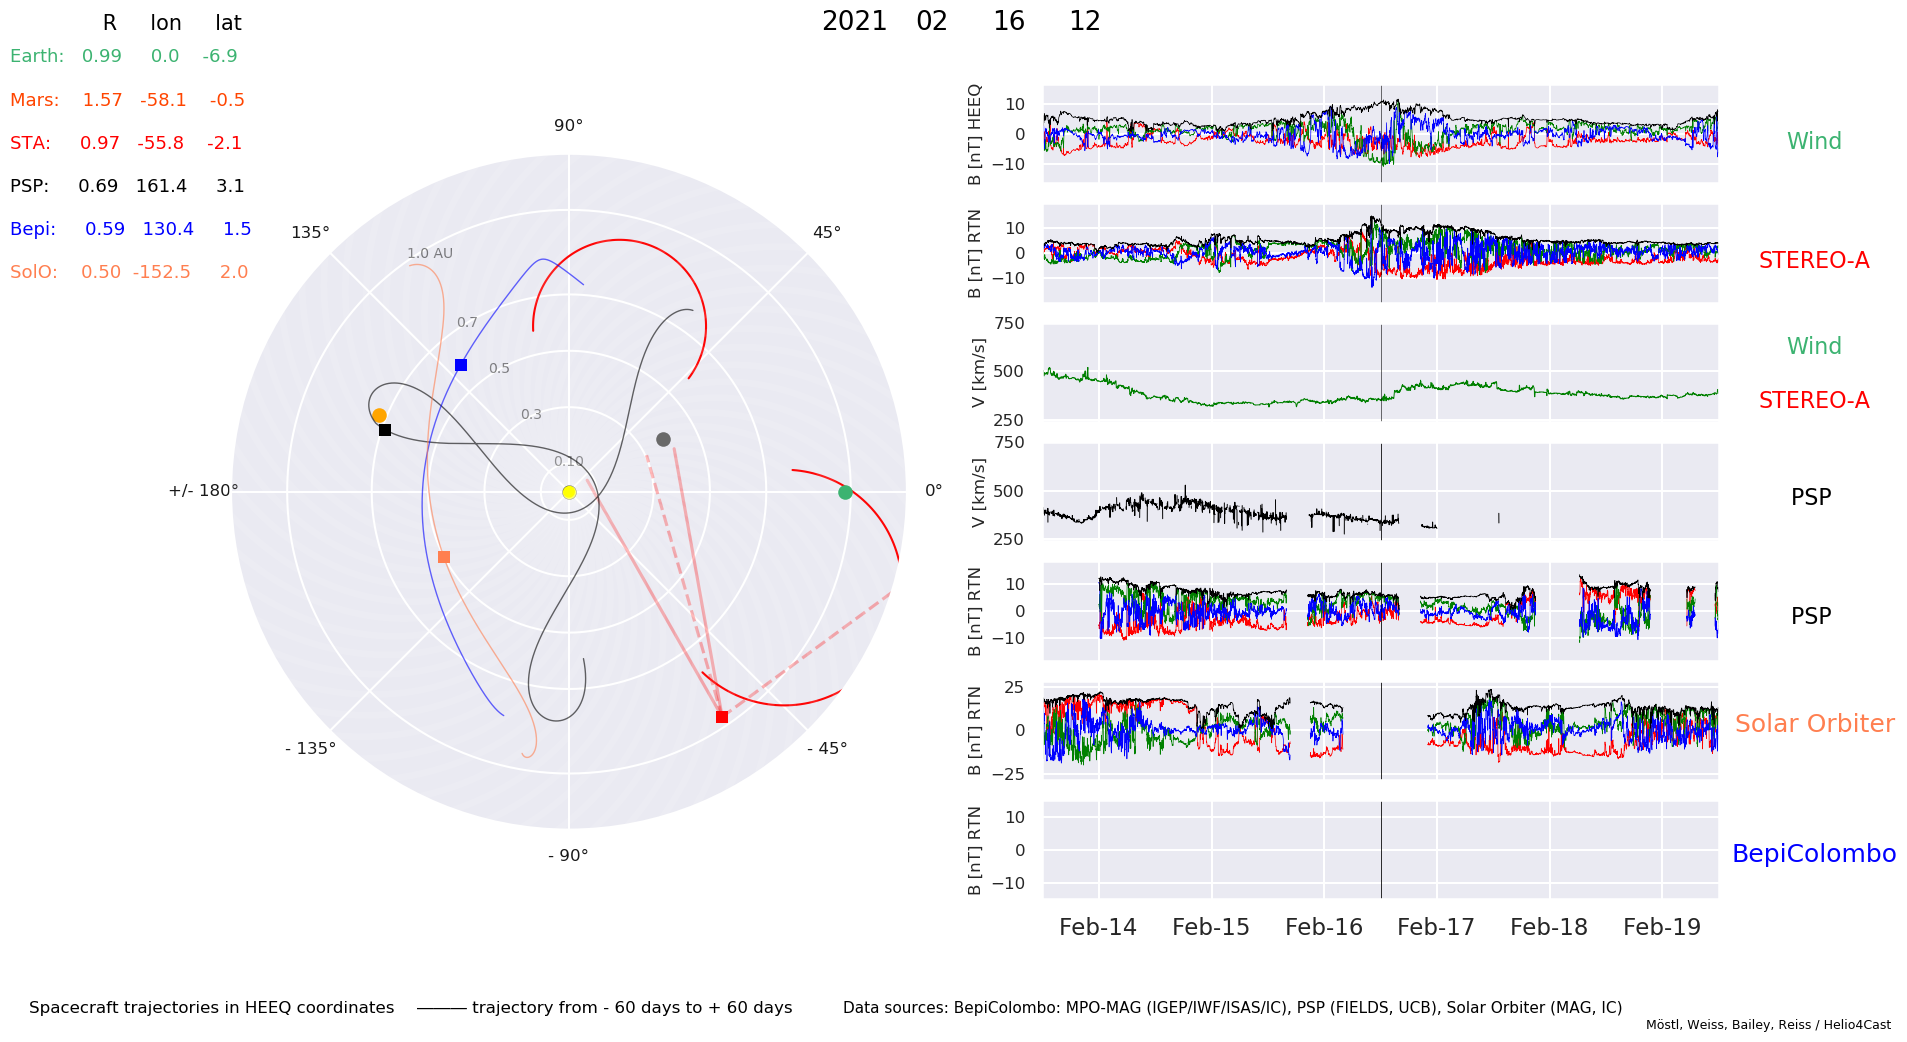

In [11]:
#for server
#matplotlib.use('Qt5Agg')

%matplotlib inline

start_time=time.time()

print()
print('make animation')

#animation start time in matplotlib format

frame_time_num=parse_time(t_start).plot_date

sns.set_context('talk')
if not black: sns.set_style('darkgrid'),#{'grid.linestyle': ':', 'grid.color': '.35'}) 
if black: sns.set_style('white',{'grid.linestyle': ':', 'grid.color': '.35'})   

# animation settings 

fsize=13
fadeind=int(60/res_in_days)

symsize_planet=110
symsize_spacecraft=80

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

######################## make frames

#for debugging
#don't close plot in make_frame when testing

make_frame2(15000)

#for i in np.arange(6454,6576,1):
#    make_frame(i)

print('done') 


## Make full movie

In [20]:
matplotlib.use('Agg')

print(k_all,' frames in total')

print()

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=100
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(k_all)]
#input=[i for i in np.arange(6721,6851,1)]
pool.map(make_frame, input)
pool.close()
# pool.join()


print('time in min: ',np.round((time.time()-start_time)/60))
print('plots done, frames saved in ',outputdirectory)
 
#os.system(ffmpeg_path+'ffmpeg -r 30 -i '+str(outputdirectory)+'/pos_anim_%05d.jpg -b 5000k \
#    -r 30 '+str(animdirectory)+'/overview_27nov_2020_from2018.mp4 -y -loglevel quiet')

#os.system(ffmpeg_path+'ffmpeg -r 30 -i '+str(outputdirectory)+'/pos_anim_%05d.jpg -b 5000k \
#    -r 30 '+str(animdirectory)+'/overview_apr2020_jul2021.mp4 -y -loglevel quiet')


os.system(ffmpeg_path+'ffmpeg -r 30 -i '+str(outputdirectory)+'/pos_anim_%05d.jpg -b 5000k \
    -r 30 '+str(animdirectory)+'/overview_apr2020_apr2021.mp4 -y -loglevel quiet')



print('movie done, saved in ',animdirectory)

17760  frames in total

Using multiprocessing, nr of cores 128 with nr of processes used:  100
results/overview_movie_apr20_apr21_frames/pos_anim_00000.jpg
time in min:  9.0
plots done, frames saved in  results/overview_movie_apr20_apr21_frames
movie done, saved in  results/overview_movie_apr20_apr21


## Lineup event images

In [41]:
#load lineup catalog
url='lineups/HELIO4CAST_multipoint_v10.csv'
lineups=pd.read_csv(url)


#alltimes are the movie frame times

#time of event 1
etime1=parse_time(lineups['event_start_time'][1]).datetime
eframe1=np.where(np.array(alltimes)> etime1)[0][0]
make_frame2(eframe1)

plt.close('all')

etime2=parse_time(lineups['event_start_time'][6]).datetime
eframe2=np.where(np.array(alltimes)> etime2)[0][0]
make_frame2(eframe2)
plt.close('all')

etime4=parse_time(lineups['event_start_time'][12]).datetime
eframe4=np.where(np.array(alltimes)> etime4)[0][0]
make_frame2(eframe4)
plt.close('all')

etime4_2=parse_time(lineups['event_start_time'][11]).datetime
eframe4_2=np.where(np.array(alltimes)> etime4_2)[0][0]
make_frame2(eframe4_2)
plt.close('all')

etime12=parse_time(lineups['event_start_time'][29]).datetime
eframe12=np.where(np.array(alltimes)> etime12)[0][0]
make_frame2(eframe12)
plt.close('all')










current frame_time_num 2020-04-19 05:30:00+00:00       443
current frame_time_num 2020-05-29 21:30:00+00:00       2395
current frame_time_num 2020-06-29 10:00:00+00:00       3860
current frame_time_num 2020-06-25 16:00:00+00:00       3680
current frame_time_num 2020-12-01 02:30:00+00:00       11285
